# Modelo predictivo para la producción cafetera

Este proyecto tiene como objetivo implementar una herramienta automatizada para predecir la cosecha de café en un intervalo de fechas dado a partir de imágenes de cafetos mediante técnicas de aprendizaje profundo. La necesidad surge en el contexto de la industria cafetera, donde una predicción precisa de las cosechas futuras es crucial para la planificación de la cosecha, la logística y la negociación de contratos de exportación, que son en su mayoria de venta a futuro.

El modelo desarrollado apunta reemplazar métodos tradicionales de muestreo manual, que resultan costosas y tediosas, por un sistema que analiza imágenes y predice cuantos kilos de café se podrán cosechar en un intervalo de fechas dado.


## Dependencias

Si esta corriendo este notebook desde Colab, **no se debe preocupar por instalar dependencias**, las celdas de abajo lo haran automaticamente.  
</br>
Si no usa Colab, puede clonar el repositorio e instalar las dependencias: `pip install requirements.txt`.

In [ ]:
import sys

if "google.colab" in sys.modules:
    !git clone --depth 1 https://github.com/JuanJoZP/coffee-production-dl.git
    !mv coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/data .
    !mv coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/src .
    !pip install ultralytics scikit-learn optuna labelme2yolo optuna-integration[pytorch_lightning]
    sys.path.append("/content/src")
    !rm -rf coffee-production-dl
    !rm /content/requirements_colab.txt

Cloning into 'coffee-production-dl'...
remote: Enumerating objects: 4726, done.
remote: Counting objects: 100% (4726/4726), done.
remote: Compressing objects: 100% (4723/4723), done.
remote: Total 4726 (delta 2), reused 4715 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (4726/4726), 357.81 MiB | 36.52 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (4715/4715), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Arquitectura de la solución

La solución propuesta se compone de una serie de modelos encadenados, cada uno encargado de una etapa específica del proceso de predicción. La arquitectura está diseñada en múltiples fases para maximizar la precisión y reducir el ruido en cada etapa:

1. Detección de Clústeres de Cerezas (Modelo detección)

   Se utiliza un modelo supervisado de detección de objetos, para localizar los clústeres o agrupaciones de cerezas de café en las ramas de los cafetos. Este modelo se reentrena con imágenes específicas de cafetos, generando bounding boxes sobre las agrupaciones visibles. Esta primera etapa permite identificar regiones candidatas para análisis más detallado.

2. Detección de Granos Individuales (Modelo detección)

    Las imágenes recortadas de los clústeres detectados en la etapa anterior se procesan con un segundo modelo de detección de objetos, también supervisado, entrenado para detectar cerezas individuales. Este enfoque en dos pasos permite reducir el ruido visual del entorno (hojas, ramas, fondo) y estandariza el tamaño de los granos dentro de una imagen más limpia y acotada. Así se mejora la precisión de detección de las cerezas, incluso en distintos estados de maduración o tamaños.


3. Estimación del Tiempo de Maduración (Modelo regresión)

   Una vez aislado cada grano, se utiliza un modelo de regresión supervisado que estima cuántos días faltan para que esa cereza esté listo para cosecha. El modelo puede usar como entrada la imagen segmentada de la cereza o descriptores derivados de ella, y fue entrenado con ejemplos etiquetados manualmente, basado en conocimiento y experiencia directa con el cultivo del café.

4. Cálculo de Producción en un Intervalo de Fechas

   Finalmente, el sistema filtra las cerezas que estarán listos para cosecha dentro de un intervalo de fechas de interes, estima el número total de cerezas cosechables, y multiplica este número por un peso promedio por grano para obtener una predicción final en kilos. Con esto se podría generar automáticamente un reporte temporal, por ejemplo con la producción proyectada cada dos semanas, facilitando la planificación logística, de mano de obra y de contratos de exportación.

## Implementación

### 1. Detección Clusteres

Se etiquetaron manualmente los clusters de granos para las 20 fotos que componen nuestro dataset, se hizo uso del software Labelme.  

Una imagen etiquetada se ve así:

![img1.png](https://raw.githubusercontent.com/JuanJoZP/coffee-production-dl/67835c31929d3b8e43dda8b0ab66c82f4e01ec86/ProduccionCafe_JuanPacheco_JuanZuluaga/src/notebook_imgs/img1.png)

Se genera el dataset en formato YOLO a partir de las imagenes etiquetadas con labelme.

In [1]:
import sys

if "google.colab" in sys.modules:
  DATA_PATH = "/content/data"
  RUNS_PATH = "/content/runs"
else:
  DATA_PATH = "../data"
  RUNS_PATH = "./runs"

In [ ]:
json_dir = f"{DATA_PATH}/labeled/clusters"
!labelme2yolo --val_size 0.2 --test_size 0.1 --output_format bbox --json_dir {json_dir}

[2025-05-25T03:41:43Z INFO  labelme2yolo] Starting the conversion process...
[2025-05-25T03:41:43Z INFO  labelme2yolo] Read and parsed 20 JSON files.
⠁ [Train] [00:00:00] [########################################] 14/14 (0s)
  [Train] [00:00:00] [########################################] 14/14 (0s)
⠁ [Val] [00:00:00] [########################################] 4/4 (0s)
  [Val] [00:00:00] [########################################] 4/4 (0s)
⠁ [Test] [00:00:00] [########################################] 2/2 (0s)
  [Test] [00:00:00] [########################################] 2/2 (0s)
[2025-05-25T03:41:43Z INFO  labelme2yolo] Creating dataset.yaml file...
[2025-05-25T03:41:43Z INFO  labelme2yolo] Conversion process completed successfully.


Se reentrena el modelo `yolov8l`, hacemos uso del metodo `tune` el cual hace uso de un algoritmo propio de ultralytics para ajustar los hiperparametros.

In [38]:
from ultralytics import YOLO
import os

if not os.path.exists(f"{DATA_PATH}/models/clusters_best.pt"):
  model = YOLO("yolov8l.pt")
  clusters_best_params = model.tune(
      data=f"{DATA_PATH}/labeled/clusters/YOLODataset/dataset.yaml",
      iterations=10,
      name="tune_clusters",
      exist_ok=True,
      deterministic=True
  )

  clusters_best = YOLO(f"{RUNS_PATH}/detect/tune_clusters/weights/best.pt")
  val = clusters_best.val(data=f"{DATA_PATH}/labeled/clusters/YOLODataset/dataset.yaml")
else:
  print("El modelo ya fue entrenado previamente.")
  clusters_best = YOLO(f"{DATA_PATH}/models/clusters_best.pt")
  val = clusters_best.val(data=f"{DATA_PATH}/labeled/clusters/YOLODataset/dataset.yaml", verbose=False)

El modelo ya fue entrenado previamente.
Ultralytics 8.3.144 🚀 Python-3.10.15 torch-2.7.0+cu126 CPU (AMD Ryzen 5 2600 Six-Core Processor)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 809.9±125.3 MB/s, size: 2263.2 KB)


val: Scanning /home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZulu

val: New cache created: /home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZuluaga/data/labeled/clusters/YOLODataset/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100


                   all          4         60      0.691      0.533      0.638      0.336
Speed: 1.1ms preprocess, 869.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val3


In [39]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
print("Métricas del mejor modelo en validación:")
pp.pprint(val.summary()[0])

Métricas del mejor modelo en validación:
{   'box-f1': np.float64(0.6020231941683802),
    'box-map': np.float64(0.3364201313303365),
    'box-map50': np.float64(0.6384198050869281),
    'box-map75': np.float64(0.3219525940911849),
    'box-p': np.float64(0.6910223771431264),
    'box-r': np.float64(0.5333333333333333),
    'class_name': 'cluster'}


Veamos como se comporta el modelo sobre las imágenes de test.

In [40]:
import os
import cv2
import matplotlib.pyplot as plt

def read_labels(label_path):
    labels = []
    with open(label_path, "r") as f:
        for line in f.readlines():
            labels.append(line.strip().split()[1:])
    return labels

def draw_boxes(image, labels, color, thick):
    h, w, _ = image.shape
    for label in labels:
        x, y, width, height = map(float, label)
        x, y, width, height = int(x * w), int(y * h), int(width * w), int(height * h)
        cv2.rectangle(image, (x-width//2, y-height//2), (x + width//2, y + height//2), color, thick)
    return image

In [41]:
confidence_threshold_clusters = 0.7
iou_threshold_clusters = 0.7

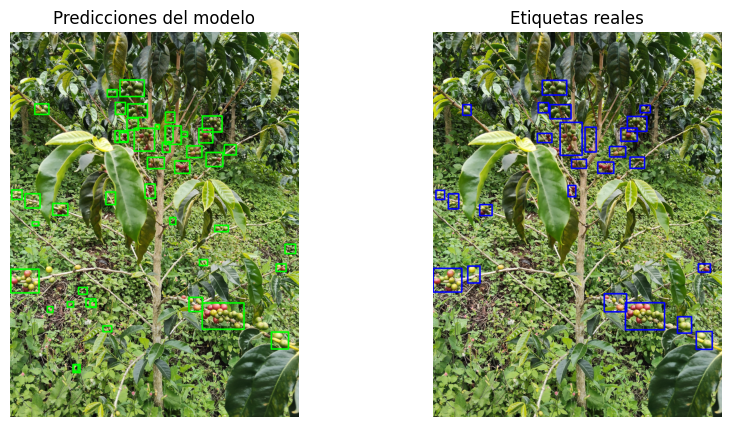

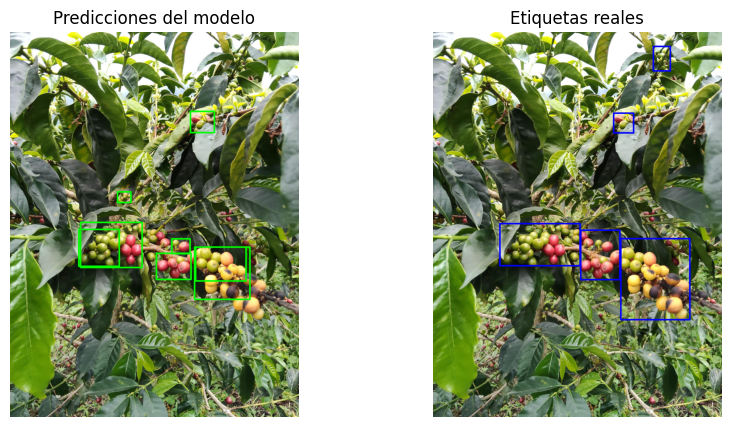

In [42]:
%matplotlib inline
test_img_folder = f"{DATA_PATH}/labeled/clusters/YOLODataset/images/test"
test_label_folder = f"{DATA_PATH}/labeled/clusters/YOLODataset/labels/test"

for img_name in os.listdir(test_img_folder):
    img_path = os.path.join(test_img_folder, img_name)
    label_path = os.path.join(test_label_folder, img_name.replace(".jpeg", ".txt"))

    img = cv2.imread(img_path)

    results = clusters_best.predict(source=img_path, conf=confidence_threshold_clusters, iou=iou_threshold_clusters, verbose=False)
    pred_labels = results[0].boxes.xywhn.tolist()
    real_labels = read_labels(label_path)

    img_pred = draw_boxes(img.copy(), pred_labels, (0, 255, 0), 15)  # Verde para predicciones
    img_real = draw_boxes(img.copy(), real_labels, (255, 0, 0), 15)  # Rojo para etiquetas reales

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Predicciones del modelo")
    axes[1].imshow(cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Etiquetas reales")

    for ax in axes:
        ax.axis("off")

    plt.show()

A pesar de que las métricas del modelo no son excelentes, sus resultados en la práctica si lo son, podemos ver que **casi nunca deja cerezas sin detectar**, por lo que tomaremos este modelo.

A continuación se va a guardar las nuevas cajas como imagenes separadas en `data/clusters`.

In [44]:
import glob
import numpy as np

raw_image_dir = f'{DATA_PATH}/raw'
clustered_output_dir = f'{DATA_PATH}/clusters'
os.makedirs(clustered_output_dir, exist_ok=True)

image_files = glob.glob(os.path.join(raw_image_dir, '*.jpg'))
for image_path in image_files:
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        continue

    results = clusters_best.predict(source=image_path, conf=confidence_threshold_clusters, iou=iou_threshold_clusters, verbose=False)

    if results and len(results) > 0:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        confidences = results[0].boxes.conf.cpu().numpy()
    else:
        boxes = np.array([])
        confidences = np.array([])
        print(f"No detections found for {image_path}")

    if boxes.size == 0:
        continue

    image_name = os.path.splitext(os.path.basename(image_path))[0]
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(image.shape[1], x2)
        y2 = min(image.shape[0], y2)

        cropped_image = image[int(y1):int(y2), int(x1):int(x2)]

        output_filename = f"{image_name}_cluster_{i}.png"
        output_path = os.path.join(clustered_output_dir, output_filename)

        cv2.imwrite(output_path, cropped_image)

print("Procesamiento completado. Imagenes guardadas en: ", clustered_output_dir)

Procesamiento completado. Imagenes guardadas en:  ../data/clusters


### 2. Detección Cerezas de café

Se etiquetaron manualmente las cerezas para algúnas fotos de los clusters que fueron generadas en el paso anterior, nuevamnete se hizo uso del software Labelme.  

Se etiquetaron las cerezas en dos categorias: verde y roja.

Una imagen etiquetada se ve así:

![img2.png](https://raw.githubusercontent.com/JuanJoZP/coffee-production-dl/refs/heads/main/ProduccionCafe_JuanPacheco_JuanZuluaga/src/notebook_imgs/img2.png)

Al igual que con los clusters, se intenta tener la mayor precisión y cuidado para cada cereza, de modo que podamos facilitar el entrenamiento de YOLO y obtener buenos resultados.

Se genera el dataset en formato YOLO a partir de las imagenes etiquetadas con labelme.


In [ ]:
json_dir = f"{DATA_PATH}/labeled/cherries"
!labelme2yolo --val_size 0.2 --test_size 0.05 --output_format bbox --json_dir {json_dir}

[2025-05-24T20:36:57Z INFO  labelme2yolo] Starting the conversion process...
[2025-05-24T20:36:57Z INFO  labelme2yolo] Read and parsed 37 JSON files.
⠁ [Train] [00:00:00] [########################################] 27/27 (0s)
  [Train] [00:00:00] [########################################] 27/27 (0s)
⠁ [Val] [00:00:00] [########################################] 8/8 (0s)
  [Val] [00:00:00] [########################################] 8/8 (0s)
⠁ [Test] [00:00:00] [########################################] 2/2 (0s)
  [Test] [00:00:00] [########################################] 2/2 (0s)
[2025-05-24T20:36:57Z INFO  labelme2yolo] Creating dataset.yaml file...
[2025-05-24T20:36:57Z INFO  labelme2yolo] Conversion process completed successfully.


Para este paso vamos a usar el modelo `yolov8m`, nuevamente ajustamos hiperparametros con el metodo `tune`.

Vamos también a apagar algunas neuronas para reducir el tiempo de entrenamiento y evitar overfitting, también vamos a reducir el tamaño de la imagen de entrada, no solo para reducir complejidad computacional, sino porque las imagenes de este dataset son mucho más pequeñas.

In [20]:
from ultralytics import YOLO
import os

if not os.path.exists(f"{DATA_PATH}/models/cherries_best.pt"):
  model = YOLO("yolov8m.pt")
  cherries_best_params = model.tune(
      data=f"{DATA_PATH}/labeled/cherries/YOLODataset/dataset.yaml",
      iterations=20,
      imgsz=256,
      dropout=0.1,
      name="tune_cherries",
      exist_ok=True,
      deterministic=True,
      verbose=False
  )

  cherries_best = YOLO(f"{RUNS_PATH}/detect/tune_cherries/weights/best.pt")
  val = cherries_best.val(data=f"{DATA_PATH}/labeled/cherries/YOLODataset/dataset.yaml", verbose=False)
else:
  print("El modelo ya fue entrenado previamente.")
  cherries_best = YOLO(f"{DATA_PATH}/models/cherries_best.pt")
  val = cherries_best.val(data=f"{DATA_PATH}/labeled/cherries/YOLODataset/dataset.yaml", verbose=False)

El modelo ya fue entrenado previamente.
Ultralytics 8.3.144 🚀 Python-3.10.15 torch-2.7.0+cu126 CPU (AMD Ryzen 5 2600 Six-Core Processor)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 235.9±133.4 MB/s, size: 94.3 KB)


val: Scanning /home/juanjozp/Desktop/coffee-production-dl/ProduccionCafe_JuanPacheco_JuanZulu
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100


                   all          8         79      0.967      0.943      0.978       0.83
Speed: 0.3ms preprocess, 105.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val2


In [29]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
print("Métricas del mejor modelo en validación:")
for metric in val.summary():
    pp.pprint(metric)

Métricas del mejor modelo en validación:
{   'box-f1': np.float64(0.9545503748871157),
    'box-map': np.float64(0.8296603414801698),
    'box-map50': np.float64(0.9780998482478913),
    'box-map75': np.float64(0.947254587325159),
    'box-p': np.float64(0.9394451820325559),
    'box-r': np.float64(0.9701492537313433),
    'class_name': 'verde'}
{   'box-f1': np.float64(0.9538867995921039),
    'box-map': np.float64(0.8296603414801698),
    'box-map50': np.float64(0.9780998482478913),
    'box-map75': np.float64(0.947254587325159),
    'box-p': np.float64(0.9942574101005133),
    'box-r': np.float64(0.9166666666666666),
    'class_name': 'rojo'}


Veamos como se comporta el modelo con las imagenes de test.

In [30]:
confidence_threshold_cherries = 0.7
iou_threshold_cherries = 1.0

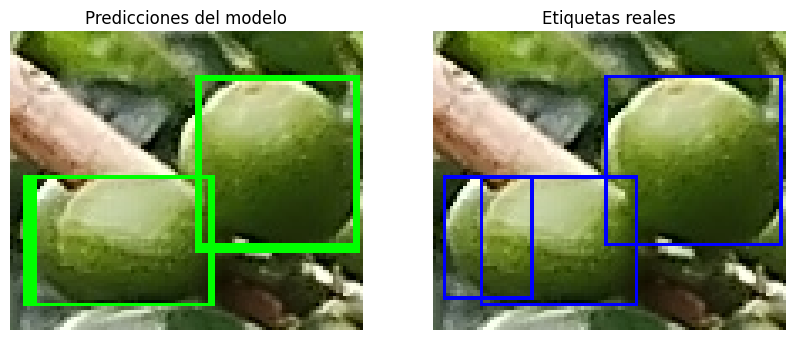

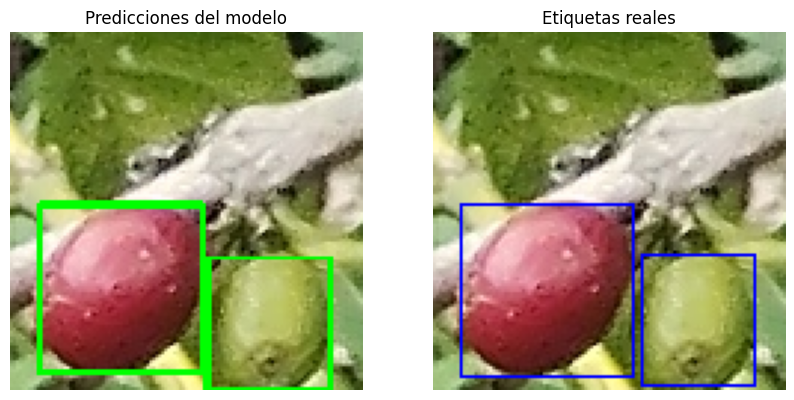

In [35]:
%matplotlib inline
test_img_folder = f"{DATA_PATH}/labeled/cherries/YOLODataset/images/test"
test_label_folder = f"{DATA_PATH}/labeled/cherries/YOLODataset/labels/test"

for img_name in os.listdir(test_img_folder):
    img_path = os.path.join(test_img_folder, img_name)
    label_path = os.path.join(test_label_folder, img_name.replace(".png", ".txt"))

    img = cv2.imread(img_path)

    results = cherries_best.predict(source=img_path, conf=confidence_threshold_cherries, iou=iou_threshold_cherries, verbose=False)
    pred_labels = results[0].boxes.xywhn.tolist()
    real_labels = read_labels(label_path)

    img_pred = draw_boxes(img.copy(), pred_labels, (0, 255, 0), 1)
    img_real = draw_boxes(img.copy(), real_labels, (255, 0, 0), 1)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Predicciones del modelo")
    axes[1].imshow(cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Etiquetas reales")

    for ax in axes:
        ax.axis("off")

    plt.show()

Vemos nuevamente que el modelo obtuvo unos muy buenos resultados, resaltando la precisión de la etiquetada de los clusters. Los granos se identifican bien y casi en su totalidad.

A continuación vamos a guardar las imagenes de las cerezas individuales en `data/cherries`.

In [43]:
import glob
import numpy as np

raw_image_dir = f'{DATA_PATH}/clusters'
output_dir = f'{DATA_PATH}/cherries'
os.makedirs(os.path.join(output_dir, "verde"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "rojo"), exist_ok=True)

image_files = glob.glob(os.path.join(raw_image_dir, '*.png'))
for image_path in image_files:
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        continue

    results = cherries_best.predict(source=image_path, conf=confidence_threshold_cherries, iou=iou_threshold_cherries, verbose=False)

    if results and len(results) > 0:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        clases = results[0].boxes.cls.cpu().numpy()
    else:
        boxes = np.array([])
        print(f"No detections found for {image_path}")

    if boxes.size == 0:
        continue

    image_name = os.path.splitext(os.path.basename(image_path))[0]
    for i, (box, cls) in enumerate(zip(boxes, clases)):
        x1, y1, x2, y2 = box
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(image.shape[1], x2)
        y2 = min(image.shape[0], y2)

        cropped_image = image[int(y1):int(y2), int(x1):int(x2)]
        class_dir = results[0].names[cls]
        output_filename = f"{image_name}_cherry_{i}.png"
        output_path = os.path.join(output_dir, class_dir, output_filename)
        cv2.imwrite(output_path, cropped_image)

print("Procesamiento completo. Imagenes guardadas en: ", output_dir)

Procesamiento completo. Imagenes guardadas en:  ../data/cherries


### 4. Estimación del Tiempo de Maduración

Para este paso, se seleccionaron 300 imagenes de granos (150 rojos y 150 verdes) del modelo anterior y se aproximó su tiempo de maduración dependiendo del aspecto visual de cada grano. Cabe recalcar que este proceso se hizo a mano.

Para los granos rojos, se estableció un tiempo de cosecha de entre 1 y 5 días. Mientras que para los granos verdes, ya más dependientes de su coloración, se estableció un tiempo de cosecha aproximado de entre 1 y 3 meses. Lo anterior basandonos en datos de internet y experiencia propia de uno de los integrantes del proyeto, quien cuenta con una cosecha real de café.

In [4]:
IMAGES_DIR = f"{DATA_PATH}/cherries"
LABELS_FILE = f"{DATA_PATH}/labeled/days_to_harvest/labels.csv"

Se aplicará un modelo de regresión para predecir días hasta la cosecha a partir de las imágenes. Vamos a probar una red neuronal convolucional (CNN) con optimización de hiperparámetros y también modelos clásicos como Ridge, SVR y Gradient Boosting, tras una reducción de dimensionalidad.

#### 4.1 Regresión con CNN

La clase CNNTrainer hace varias cosas:
1. Carga el datast y extiende el conjunto de entrenamiento al aplicar rotaciones, flips y ruidos aleatorios (data augmentation).
2. Define una arquitectura CNN personalizada que consiste de dos bloques:
   - Feature extraction: toma como input la imagen y aplica cinco convoluciones diferentes, cada una seguida de un batch normalization, activación ReLU, una capa de pooling y un dropout.
   - Clasificación: las features de la imagen se aplanan, se concatena con la clase de la imagen (rojo o verde), y pasa por tres capas fully conected con activacion ReLU.
3. Implementa el metodo de entrenamiento con precisión mixta, que reduce costos computacionales hasta en un 50%.
3. Realiza 20 iteraciones de optimización de hiperparámetros con el framework Optuna.
4. Entrena el mejor modelo por otras cien epocas y lo evalúa sobre el conjunto de prueba.

In [19]:
from harvestDLEstimator import CNNTrainer
import torch
import torch.nn as nn

cnn_trainer = CNNTrainer(LABELS_FILE, IMAGES_DIR)

if not os.path.exists(f"{DATA_PATH}/models/days_to_harvest_best_cnn.pt"):
    best_cnn_params = cnn_trainer.optimize_hyperparameters(n_trials=30)
    best_cnn_model, cnn_test_loss, cnn_test_r2, cnn_test_mae = cnn_trainer.train_best_model()

    torch.save(best_cnn_model, f"{DATA_PATH}/models/days_to_harvest_best_cnn.pt")
else:
    criterion = nn.MSELoss()
    _, _, test_loader = cnn_trainer.create_data_loaders()
    best_cnn_model = torch.load(f"{DATA_PATH}/models/days_to_harvest_best_cnn.pt", weights_only=False, map_location=torch.device('cpu'))
    test_loss, test_r2, test_mae, test_preds, test_actual = cnn_trainer.validate(best_cnn_model, test_loader, criterion)

    print(f"\nResultados finales:")
    print(f"Test Loss (MSE): {test_loss:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test RMSE: {np.sqrt(test_loss):.4f}")


Resultados finales:
Test Loss (MSE): 144.7806
Test R²: 0.8980
Test MAE: 8.3625
Test RMSE: 12.0325


#### 4.2 Regresión con reducción de dimensionalidad + ML clásico

la clase MLPipeline hace varias cosas:
1. Carga las imágenes y su etiquetas en una matriz, aplica normalizacion con `StandardScaler`.
2. Aplica reducción de dimensionalidad con PCA o UMAP y escoge la mejor.
3. Optimiza hiperparametros de tres modelos de regresión (Ridge, SVR, GradientBoosting) con `RandomSearchCV`, y evalúa el mejor en el conjunto de prueba.

In [ ]:
from harvestMLEstimator import MLPipeline

ml_pipeline = MLPipeline(LABELS_FILE, IMAGES_DIR)
ml_pipeline.load_and_preprocess_data()
best_dim_reduction = ml_pipeline.evaluate_dimensionality_reduction()
best_models, best_model_name = ml_pipeline.optimize_models()
ml_test_r2, ml_test_mae, ml_test_rmse, ml_test_pred = ml_pipeline.evaluate_best_model()

Data loaded: Train (212, 6913), Val (77, 6913), Test (16, 6913)
Evaluating dimensionality reduction methods...

Best dimensionality reduction method: PCA_50
Score (R²): 0.8892
Reduced dimensions: 50
Optimizing regression models...
Optimizing GradientBoosting...
GradientBoosting - Val R²: 0.9247, MAE: 6.2534, RMSE: 10.4622
Optimizing SVR...
SVR - Val R²: 0.8317, MAE: 12.5885, RMSE: 15.6395
Optimizing Ridge...
Ridge - Val R²: 0.8919, MAE: 10.0353, RMSE: 12.5344

Mejor modelo: GradientBoosting
Con parametros: {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 7, 'learning_rate': 0.01}

Final Test Results:
Test R²: 0.7809
Test MAE: 10.1630
Test RMSE: 17.3226


El modelo CNN superó claramente al modelo clásico (GradientBoosting), obteniendo un R² de 0.94 frente a 0.78 y un MAE de 6.2 frente a 10.1. Esto indica que la CNN capturó mejor patrones visuales en las imágenes. Por su mayor precisión y menor error, se eligió la CNN como modelo final. (si corre el codigo puede que las métricas de CNN difieran un poco ya que la red no es deterministica)